In [1]:
import folium
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from folium.plugins import MarkerCluster, FeatureGroupSubGroup, HeatMap

import plotly.express as px
sns.set()
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [3]:
df_posts = pd.read_json('data/alert_mpk_facebook_posts.json', lines=True)
df_posts['angry'] = [reaction.get('Angry') for reaction in df_posts.reactions]
df_posts['haha'] = [reaction.get('Haha') for reaction in df_posts.reactions]
df_posts['like'] = [reaction.get('Like') for reaction in df_posts.reactions]
df_posts['love'] = [reaction.get('Love') for reaction in df_posts.reactions]
df_posts['sad'] = [reaction.get('Sad') for reaction in df_posts.reactions]
df_posts['wow'] = [reaction.get('Wow') for reaction in df_posts.reactions]
df_posts['lat'] = [position[0] if isinstance(position, list) else position for position in df_posts.position]
df_posts['lon'] = [position[1] if isinstance(position, list) else position for position in df_posts.position]
df_posts = df_posts.drop(['reactions', 'position'], axis=1)
df_posts.groupby('label').id.nunique()

label
accident       111
event           91
fix              9
incident       100
malfunction    224
renovation      40
unknown         47
Name: id, dtype: int64

In [4]:
main_lables = ['incident', 'accident', 'malfunction', 'unknown']

In [5]:
df_posts = df_posts[df_posts['label'].isin(main_lables)]
df_posts = df_posts[(df_posts['lat'].notna()) & (df_posts['lon'].notna())]
df_posts.timestamp = pd.to_datetime(df_posts.timestamp, format='%Y-%m-%d %H:%M:%S')
df_posts['year'] = df_posts.timestamp.apply(lambda x: x.year)
df_posts['month'] = df_posts.timestamp.apply(lambda x: x.month)
df_posts['day'] = df_posts.timestamp.apply(lambda x: x.day)
df_posts['hour'] = df_posts.timestamp.apply(lambda x: x.hour)
df_posts['weekday'] = df_posts.timestamp.apply(lambda x: x.weekday())
df_posts['negative_comm'] = 0
df_posts['positive_comm'] = 0
df_posts['neutral_comm'] = 0
df_posts['comments_count'] = 0
df_posts['count'] = 1
df_posts.head()

,id,text,timestamp,label,angry,haha,like,love,sad,wow,...,year,month,day,hour,weekday,negative_comm,positive_comm,neutral_comm,comments_count,count
0,5dda5783073b739b4a9aa6fd,#AlertMPK - #TRAM\nAKTUALIZACJA 10:01\nRuch pr...,2017-03-20 09:51:26,malfunction,0,0,6,3,0,0,...,2017,3,20,9,0,0,0,0,0,1
1,5dda54a6073b739b4a9aa6e8,#AlertMPK\nAKTUALIZACJA 15:27\nKoniec utrudnie...,2017-03-21 15:20:34,unknown,0,0,4,1,0,0,...,2017,3,21,15,1,0,0,0,0,1
3,5dda387a073b739b4a9aa6c4,#AlertMPK\nAKTUALIZACJA 19:52\nKoniec utrudnie...,2017-03-22 20:21:20,incident,0,8,35,3,1,21,...,2017,3,22,20,2,0,0,0,0,1
4,5dda34b2073b739b4a9aa67a,#AlertMPK\nAKTUALIZACJA 20:11\nRuch normalny.\...,2017-03-27 20:17:35,unknown,0,0,0,0,0,0,...,2017,3,27,20,0,0,0,0,0,1
5,5dda349e073b739b4a9aa676,#AlertMPK - #BUS\nAKTUALIZACJA 15:30\nRuch nor...,2017-03-28 15:01:28,accident,0,0,0,0,0,0,...,2017,3,28,15,1,0,0,0,0,1


In [6]:
df_comments = pd.read_excel('data/comments_labeled.xlsx')
df_comments['angry'] = [json.loads(reaction.replace("'", "\"")).get('Angry') for reaction in df_comments.reactions]
df_comments['haha'] = [json.loads(reaction.replace("'", "\"")).get('Haha') for reaction in df_comments.reactions]
df_comments['like'] = [json.loads(reaction.replace("'", "\"")).get('Like') for reaction in df_comments.reactions]
df_comments['love'] = [json.loads(reaction.replace("'", "\"")).get('Love') for reaction in df_comments.reactions]
df_comments['sad'] = [json.loads(reaction.replace("'", "\"")).get('Sad') for reaction in df_comments.reactions]
df_comments['wow'] = [json.loads(reaction.replace("'", "\"")).get('Wow') for reaction in df_comments.reactions]
df_comments = df_comments.drop(['label', 'reactions', 'Unnamed: 0'], axis=1)
df_comments = df_comments.rename(columns={"predictions": "label"})
df_comments['label'] = df_comments['label'].map({'__label__0': 0, '__label__-1': -1, '__label__1': 1})
df_comments.timestamp = pd.to_datetime(df_comments.timestamp, format='%Y-%m-%d %H:%M:%S')
df_comments['year'] = df_comments.timestamp.apply(lambda x: x.year)
df_comments['month'] = df_comments.timestamp.apply(lambda x: x.month)
df_comments['day'] = df_comments.timestamp.apply(lambda x: x.day)
df_comments['hour'] = df_comments.timestamp.apply(lambda x: x.hour)
df_comments['weekday'] = df_comments.timestamp.apply(lambda x: x.weekday())
df_comments.head()

,id,post_id,timestamp,commenter_name,reference_commenter,comment_without_username,label,angry,haha,like,love,sad,wow,year,month,day,hour,weekday
0,5dda57b3073b739b4a9aa701,5dda5783073b739b4a9aa6fd,2017-03-20 09:10:40,Gozo Angelika,Katarzyna Krok,"mam nadzieje,ze jestes w Brzegu.",0,0,0,2,0,0,0,2017,3,20,9,0
1,5dda579d073b739b4a9aa6ff,5dda5783073b739b4a9aa6fd,2017-03-20 09:26:57,Konrad Słota,NaN,Już 3 awaria dziś 😂 dobry tydzień się zapowiada 😂,0,0,0,2,0,0,0,2017,3,20,9,0
2,5dda5794073b739b4a9aa6fe,5dda5783073b739b4a9aa6fd,2017-03-20 09:51:26,Iwona Ressel,NaN,A u was klasycznie - wszystkie plagi tego świa...,-1,0,0,1,0,0,0,2017,3,20,9,0
3,5dda57b5073b739b4a9aa702,5dda5783073b739b4a9aa6fd,2017-03-20 10:01:46,Dawid Filipczak,NaN,Ładnie się zaczyna nowy tydzień.,-1,0,0,0,0,0,0,2017,3,20,10,0
4,5dda57a4073b739b4a9aa700,5dda5783073b739b4a9aa6fd,2017-03-20 10:29:11,Oli Karczma,NaN,"chyba nie bardzo wróciły na swoje trasy, bo pr...",0,0,0,2,0,0,0,2017,3,20,10,0


In [7]:
for i, j in df_comments.iterrows():
    if list(df_posts.index[df_posts['id'] == j.post_id]) != []:
        if j.label == 0:
            df_posts.at[df_posts.index[df_posts['id'] == j.post_id][0], 'neutral_comm'] += 1
        elif j.label == -1:
            df_posts.at[df_posts.index[df_posts['id'] == j.post_id][0], 'negative_comm'] += 1
        else:
            df_posts.at[df_posts.index[df_posts['id'] == j.post_id][0], 'positive_comm'] += 1
        df_posts.at[df_posts.index[df_posts['id'] == j.post_id][0], 'comments_count'] += 1
df_posts.head()

,id,text,timestamp,label,angry,haha,like,love,sad,wow,...,year,month,day,hour,weekday,negative_comm,positive_comm,neutral_comm,comments_count,count
0,5dda5783073b739b4a9aa6fd,#AlertMPK - #TRAM\nAKTUALIZACJA 10:01\nRuch pr...,2017-03-20 09:51:26,malfunction,0,0,6,3,0,0,...,2017,3,20,9,0,2,0,3,5,1
1,5dda54a6073b739b4a9aa6e8,#AlertMPK\nAKTUALIZACJA 15:27\nKoniec utrudnie...,2017-03-21 15:20:34,unknown,0,0,4,1,0,0,...,2017,3,21,15,1,0,0,0,0,1
3,5dda387a073b739b4a9aa6c4,#AlertMPK\nAKTUALIZACJA 19:52\nKoniec utrudnie...,2017-03-22 20:21:20,incident,0,8,35,3,1,21,...,2017,3,22,20,2,1,0,29,30,1
4,5dda34b2073b739b4a9aa67a,#AlertMPK\nAKTUALIZACJA 20:11\nRuch normalny.\...,2017-03-27 20:17:35,unknown,0,0,0,0,0,0,...,2017,3,27,20,0,0,0,3,3,1
5,5dda349e073b739b4a9aa676,#AlertMPK - #BUS\nAKTUALIZACJA 15:30\nRuch nor...,2017-03-28 15:01:28,accident,0,0,0,0,0,0,...,2017,3,28,15,1,0,0,0,0,1


# Count of events and comments in time

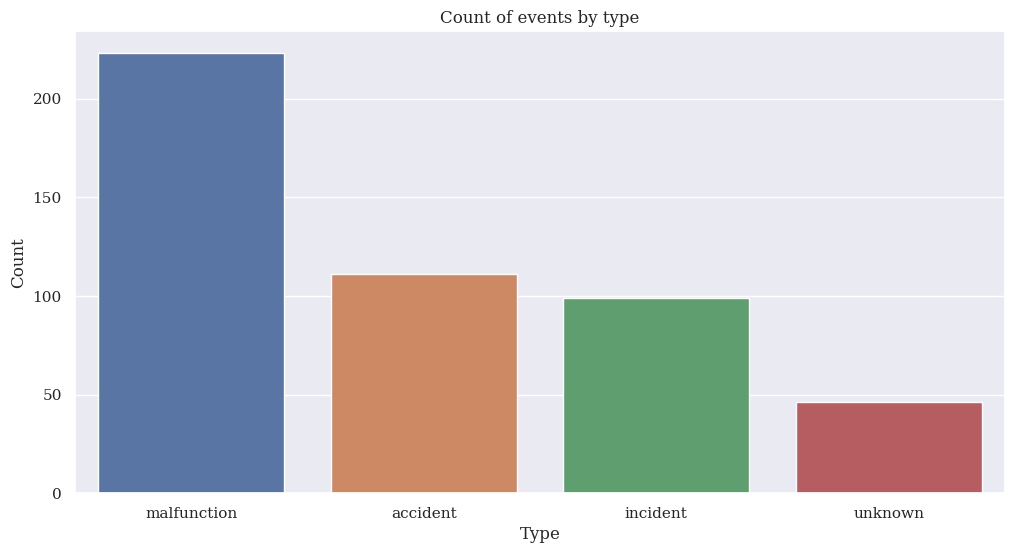

In [8]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x= 'label',data = df_posts, order = df_posts['label'].value_counts().index)
ax.set_title('Count of events by type')
ax.set(xlabel='Type', ylabel='Count')
plt.show()

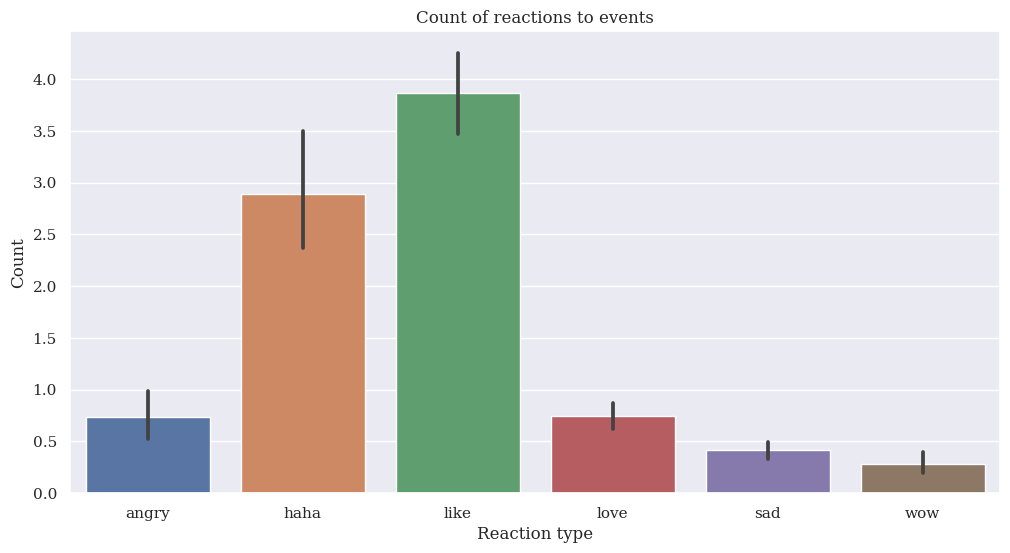

In [9]:
df_posts = df_posts.astype({'angry': 'int32', 'haha': 'int32', 'like': 'int32', 'love': 'int32', 'sad': 'int32', 'wow': 'int32'})
df_stats = df_posts.drop(['id', 'lat', 'lon', 'label', 'year', 'month', 'day', 'hour', 'negative_comm', 'positive_comm', 'neutral_comm', 'count', 'comments_count', 'text', 'weekday', 'timestamp'], axis=1)
df_stats = df_stats.melt(value_vars=df_stats.columns)
temdf_statsp = df_stats[['variable', 'value']].groupby(['variable']).sum().reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot('variable','value',data = df_stats)
ax.set_title('Count of reactions to events')
ax.set(xlabel='Reaction type', ylabel='Count')
plt.show()

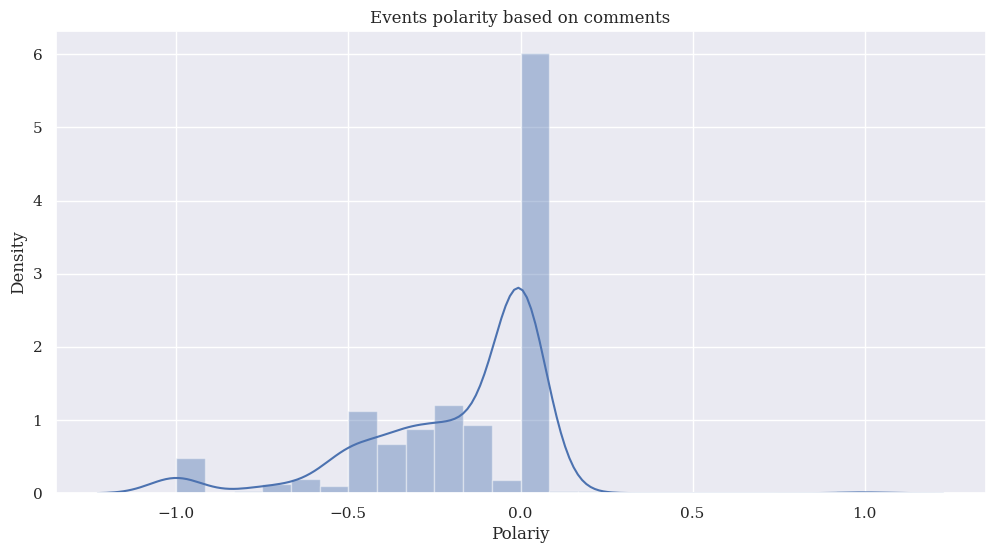

In [10]:
for i, j in df_posts.iterrows():
    df_posts.at[i,'polarity'] = 0
    pos = j.positive_comm
    neg = j.negative_comm
    cnt = j.comments_count
    if cnt > 0:
        df_posts.at[i,'polarity'] = (pos - neg) / cnt

plt.figure(figsize=(12,6))
ax = sns.distplot(df_posts['polarity'])
ax.set_title('Events polarity based on comments')
ax.set(xlabel='Polariy', ylabel='Density')
plt.show()

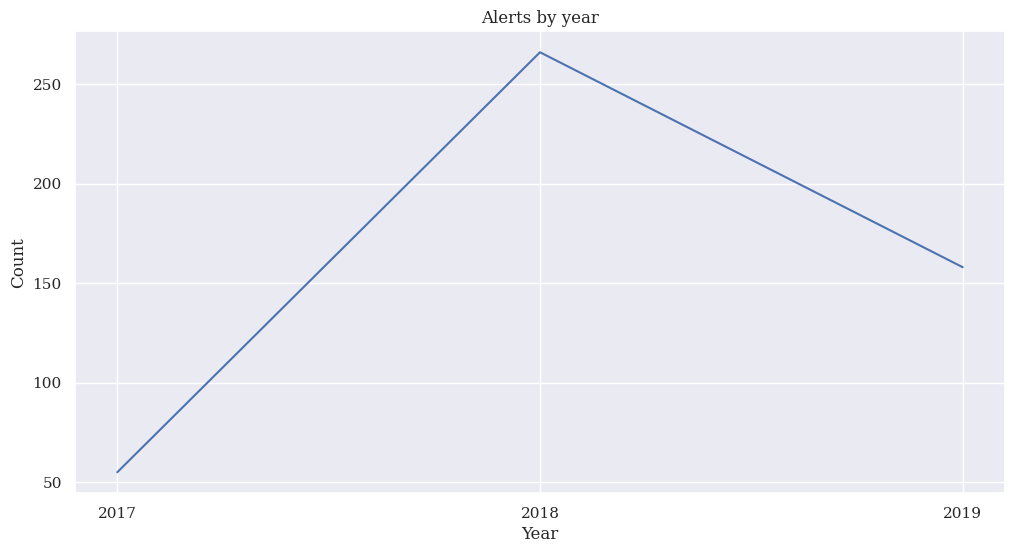

In [11]:
df_stats = df_posts.copy()
df_stats.set_index('timestamp', inplace=True)
df_stats = df_stats.resample('1Y').count()
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(df_stats['id'].values)), df_stats['id'].values)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Alerts by year')
plt.xticks(np.arange(3), ['2017', '2018', '2019'])
plt.show()

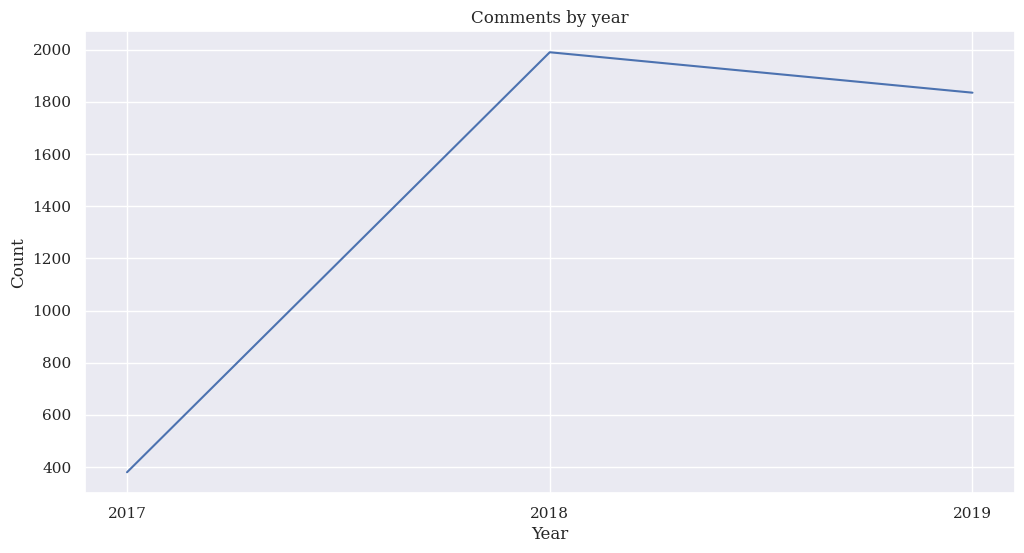

In [12]:
df_stats = df_comments.copy()
df_stats.set_index('timestamp', inplace=True)
df_stats = df_stats.resample('1Y').count()
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(df_stats['id'].values)), df_stats['id'].values)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Comments by year')
plt.xticks(np.arange(3), set(df_comments['year'].tolist()))
plt.show()

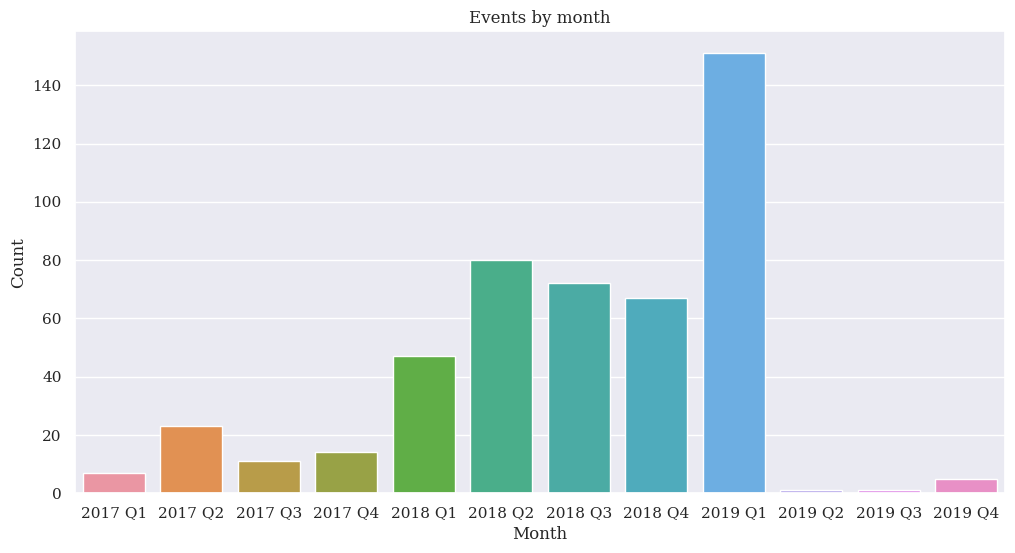

In [13]:
df_stats = df_posts.copy()
df_stats.set_index('timestamp', inplace=True)
df_stats = df_stats.resample('Q').count()
plt.figure(figsize=(12,6))
sns.barplot(np.arange(len(df_stats['id'].values)), df_stats['id'].values)
plt.ylabel('Count')
plt.xlabel('Month')
plt.title('Events by month')
quaters = [str(i)[:4] + ' Q' + str(int(int(str(i)[5:7])/3)) for i in df_stats.index.values]
plt.xticks(np.arange(len(df_stats['id'].values)), quaters)
plt.show()

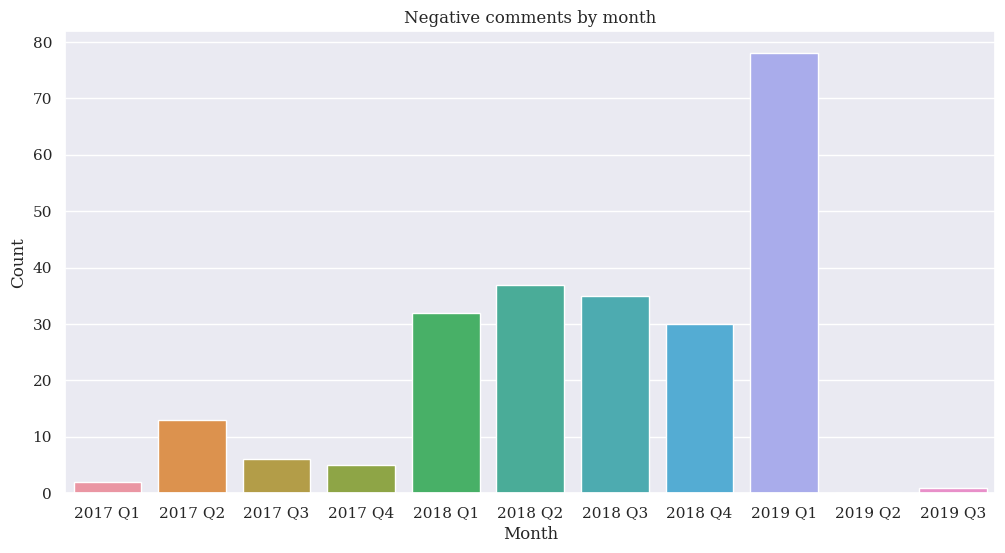

In [14]:
df_stats = df_posts[df_posts['negative_comm'] > 0]
df_stats.set_index('timestamp', inplace=True)
df_stats = df_stats.resample('Q').count()
plt.figure(figsize=(12,6))
sns.barplot(np.arange(len(df_stats['id'].values)), df_stats['id'].values)
plt.ylabel('Count')
plt.xlabel('Month')
plt.title('Negative comments by month')
quaters = [str(i)[:4] + ' Q' + str(int(int(str(i)[5:7])/3)) for i in df_stats.index.values]
plt.xticks(np.arange(len(df_stats['id'].values)), quaters)
plt.show()

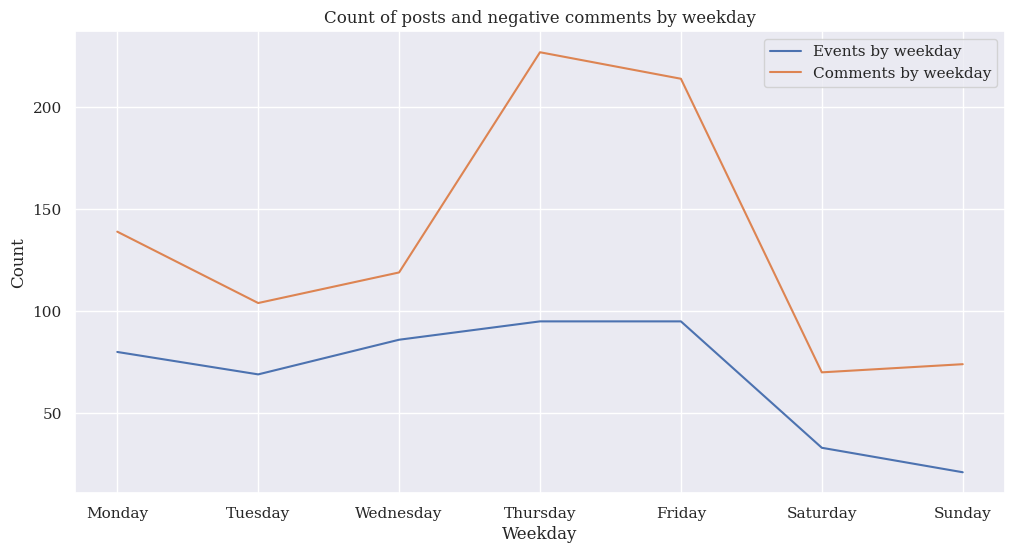

In [15]:
df_stat_events = df_posts[['count', 'weekday']].groupby(['weekday']).sum().reset_index()
df_stat_events = df_stat_events.sort_values(by=['weekday'])

df_stat_comments = df_posts[['negative_comm', 'weekday']].groupby(['weekday']).sum().reset_index()
df_stat_comments = df_stat_comments.sort_values(by=['weekday'])

plt.figure(figsize=(12,6))
plt.plot(np.arange(7), df_stat_events['count'].values, label = 'Events by weekday')
plt.plot(np.arange(7), df_stat_comments['negative_comm'].values, label = 'Comments by weekday')
plt.ylabel('Count')
plt.xlabel('Weekday')
plt.title('Count of posts and negative comments by weekday')
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday' ,'Thursday', 'Friday' ,'Saturday' ,'Sunday'])
plt.legend()
plt.show()

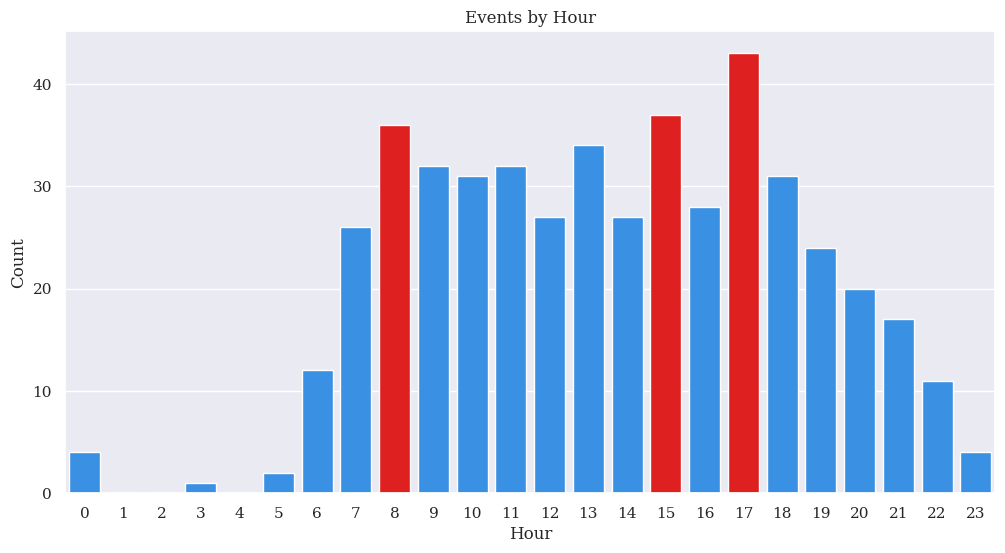

In [16]:
df_stat = df_posts[['count', 'hour']].groupby(['hour']).sum().reset_index()
df_stat = df_stat.append({'hour': 1, 'count': 0}, ignore_index=True)
df_stat = df_stat.append({'hour': 2, 'count': 0}, ignore_index=True)
df_stat = df_stat.append({'hour': 4, 'count': 0}, ignore_index=True)
df_stat = df_stat.sort_values(by=['hour'])
plt.figure(figsize=(12,6))
clrs = ['dodgerblue' if (x < df_stat['count'].nlargest(3).values[2]) else 'red' for x in df_stat['count'].values ]
sns.barplot(np.arange(24), df_stat['count'].values, palette = clrs)
plt.ylabel('Count')
plt.xlabel('Hour')
plt.title('Events by Hour')
plt.xticks(np.arange(24), np.arange(24))
plt.show()

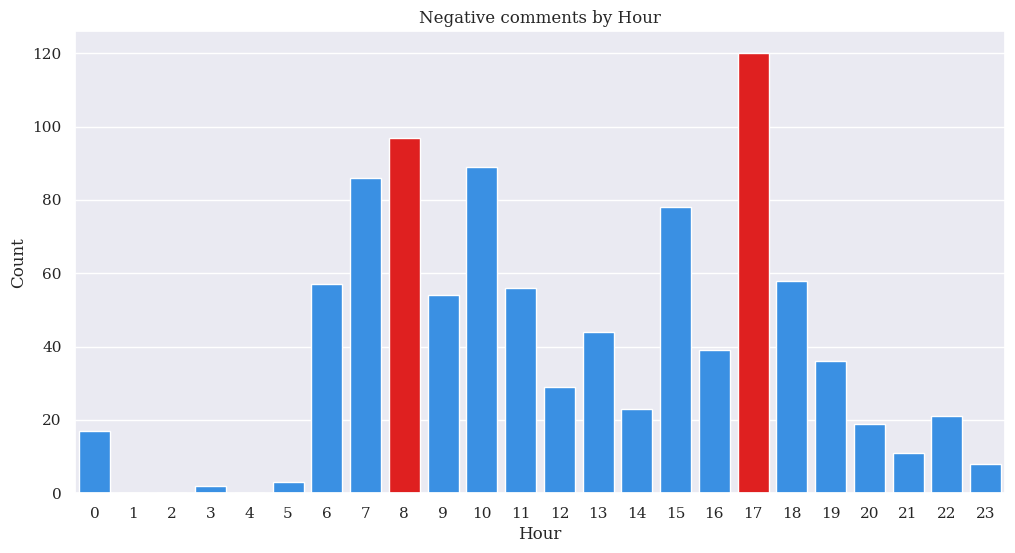

In [17]:
df_stat = df_posts[['negative_comm', 'hour']].groupby(['hour']).sum().reset_index()
df_stat = df_stat.append({'hour': 1, 'negative_comm': 0}, ignore_index=True)
df_stat = df_stat.append({'hour': 2, 'negative_comm': 0}, ignore_index=True)
df_stat = df_stat.append({'hour': 4, 'negative_comm': 0}, ignore_index=True)
df_stat = df_stat.sort_values(by=['hour'])
plt.figure(figsize=(12,6))
clrs = ['dodgerblue' if (x < df_stat.negative_comm.nlargest(2).values[1]) else 'red' for x in df_stat.negative_comm.values ]
sns.barplot(np.arange(24), df_stat['negative_comm'].values, palette=clrs)
plt.ylabel('Count')
plt.xlabel('Hour')
plt.title('Negative comments by Hour')
plt.xticks(np.arange(24), np.arange(24))
plt.show()

# What impact does the weather made

In [18]:
df_weather = pd.read_json('data/weather.json')
df_weather['temp'] = [x.get('temp')-273.15 for x in df_weather.main]
df_weather['temp_min'] = [x.get('temp_min')-273.15 for x in df_weather.main]
df_weather['temp_max'] = [x.get('temp_max')-273.15 for x in df_weather.main]
df_weather['pressure'] = [x.get('pressure') for x in df_weather.main]
df_weather['humidity'] = [x.get('humidity') for x in df_weather.main]
df_weather['wind_speed'] = [x.get('speed') for x in df_weather.wind]
df_weather['wind_deg'] = [x.get('deg') for x in df_weather.wind]
df_weather['rain'] = [True if type(i) == dict else False for i in df_weather.rain]
df_weather['snow'] = [True if type(i) == dict else False for i in df_weather.snow]
df_weather['clouds'] = [x.get('all') for x in df_weather.clouds]
df_weather['description'] = [x[0].get('description') for x in df_weather.weather]
df_weather['weather'] = [x[0].get('main') for x in df_weather.weather]
df_weather['created_at'] = pd.to_datetime(df_weather.dt_iso, format='%Y-%m-%d %H:%M:%S +0000 UTC')
df_weather = df_weather.drop(columns = ['city_id', 'main', 'wind', 'dt_iso', 'dt'])

df_weather.head()

,rain,clouds,weather,snow,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,description,created_at
0,True,99,Clear,False,12.840,12.780,13.000,1003,0,0,95,sky is clear,2012-10-01 13:00:00
1,False,75,Clouds,False,12.690,12.220,13.000,1017,87,0,0,broken clouds,2012-10-01 14:00:00
2,False,75,Clouds,False,12.682,12.682,12.682,1017,87,0,0,broken clouds,2012-10-01 15:00:00
3,False,75,Clouds,False,12.674,12.674,12.674,1017,87,0,0,broken clouds,2012-10-01 16:00:00
4,False,75,Clouds,False,12.666,12.666,12.666,1017,87,0,0,broken clouds,2012-10-01 17:00:00


In [19]:
df_posts['created_at'] = [x.round('H') for x in df_posts.timestamp]
df_posts = pd.merge(df_posts, df_weather, on='created_at', how='inner')
df_posts.head()

,id,text,timestamp,label,angry,haha,like,love,sad,wow,...,weather,snow,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,description
0,5dda5783073b739b4a9aa6fd,#AlertMPK - #TRAM\nAKTUALIZACJA 10:01\nRuch pr...,2017-03-20 09:51:26,malfunction,0,0,6,3,0,0,...,Clouds,False,12.0,12.0,12.0,1008,71,8,280,broken clouds
1,5dda54a6073b739b4a9aa6e8,#AlertMPK\nAKTUALIZACJA 15:27\nKoniec utrudnie...,2017-03-21 15:20:34,unknown,0,0,4,1,0,0,...,Clouds,False,14.0,14.0,14.0,1008,54,2,280,few clouds
2,5dda387a073b739b4a9aa6c4,#AlertMPK\nAKTUALIZACJA 19:52\nKoniec utrudnie...,2017-03-22 20:21:20,incident,0,8,35,3,1,21,...,Clouds,False,6.0,6.0,6.0,1020,81,4,140,broken clouds
3,5dda34b2073b739b4a9aa67a,#AlertMPK\nAKTUALIZACJA 20:11\nRuch normalny.\...,2017-03-27 20:17:35,unknown,0,0,0,0,0,0,...,Clear,False,7.0,7.0,7.0,1023,65,3,220,Sky is Clear
4,5dda349e073b739b4a9aa676,#AlertMPK - #BUS\nAKTUALIZACJA 15:30\nRuch nor...,2017-03-28 15:01:28,accident,0,0,0,0,0,0,...,Clear,False,20.0,20.0,20.0,1020,30,3,270,Sky is Clear


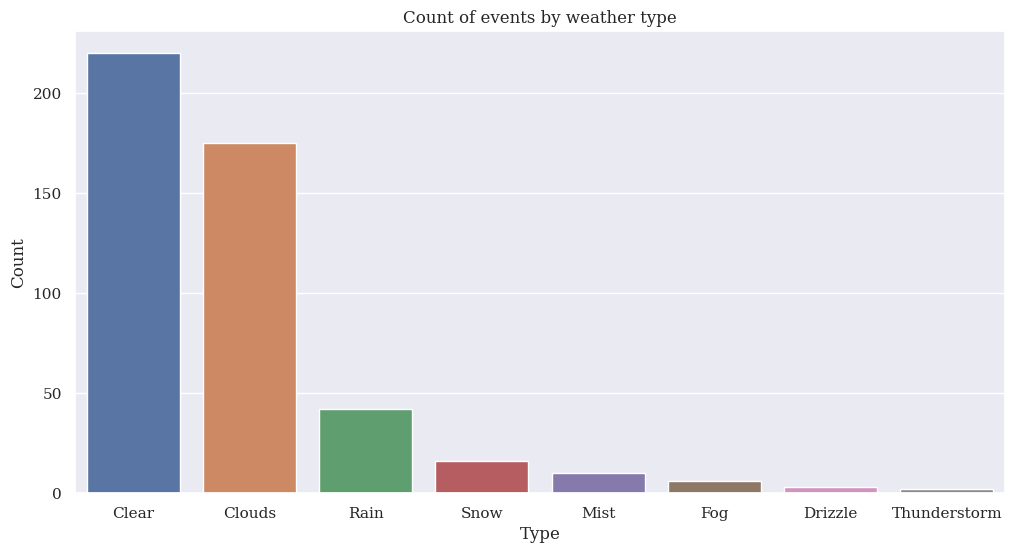

In [20]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x= 'weather',data = df_posts, order = df_posts['weather'].value_counts().index)
ax.set_title('Count of events by weather type')
ax.set(xlabel='Type', ylabel='Count')
plt.show()

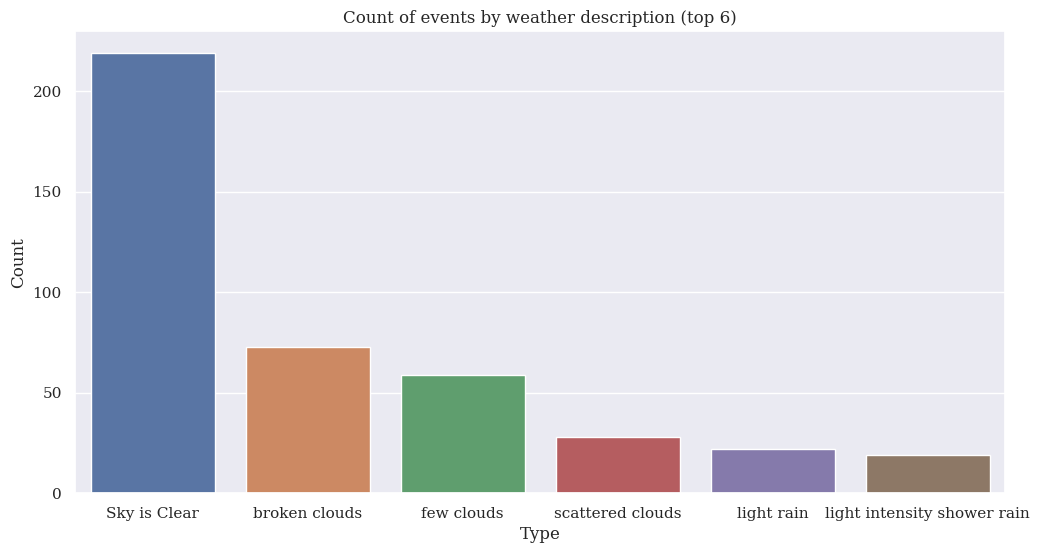

In [21]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x= 'description',data = df_posts, order = df_posts['description'].value_counts().iloc[:6].index)
ax.set_title('Count of events by weather description (top 6)')
ax.set(xlabel='Type', ylabel='Count')
plt.show()

# How the polarity of user comments has changed over the years

In [22]:
from datetime import datetime, timedelta
dt = datetime(2017, 1, 1)
comments = []
comments_x = []
comments_y = []
while dt.year < 2020:
    f_year = df_comments["year"]==dt.year
    f_month = df_comments["month"]==dt.month
    f_day = df_comments["day"]==dt.day
    cmnts = df_comments.where(f_year & f_month & f_day)
    if not cmnts.isnull().values.all():
        polarity = cmnts.label.mean()
        comments.append({
            "timestamp": dt.timestamp(),
            "date": dt,
            "polarity": polarity,
            "Wydźwięk": polarity,
            "sum": cmnts.label.count()
        })
    dt += timedelta(days=1)
polarity_cmnts_df = pd.DataFrame(comments)

polarity_cmnts_df['Liczba komentarzy'] = polarity_cmnts_df['sum']

In [23]:
d = 30
global_date = None
df_temp = pd.DataFrame(columns=['timestamp', 'date', 'polarity', 'summ'])
df_result = pd.DataFrame(columns=['timestamp', 'date', 'polarity', 'summ'])
for i,j in polarity_cmnts_df.iterrows():
    if global_date == None:
        global_date = j.date + timedelta(days=d)
    if j.date < global_date:
        df_temp = df_temp.append({'timestamp': j.timestamp, 'date': j.date, 'polarity': j.polarity, 'summ': j['sum']}, ignore_index=True)
    else:
        global_date = global_date - timedelta(days=d/2)
        timestamp = global_date.timestamp()
        date = global_date
        mean = df_temp.polarity.mean()
        s_sum = df_temp['summ'].sum()
        df_result = df_result.append({'timestamp': timestamp, 'date': date, 'polarity': mean, 'summ': s_sum}, ignore_index=True)
        df_temp = pd.DataFrame(columns=['timestamp', 'date', 'polarity', 'summ'])
        global_date = global_date + timedelta(days=d+d/2)

df_result['Wydźwięk'] = df_result['polarity']
df_result['Liczba komentarzy'] = df_result['summ']
df_result = df_result.astype({'Liczba komentarzy': 'int64'})
df_result.head()

,timestamp,date,polarity,summ,Wydźwięk,Liczba komentarzy
0,1.491264e+09,2017-04-04,-0.165229,80,-0.165229,80
1,1.493856e+09,2017-05-04,-0.323810,31,-0.323810,31
2,1.496448e+09,2017-06-03,-0.151488,65,-0.151488,65
3,1.499040e+09,2017-07-03,-0.234921,28,-0.234921,28
4,1.501632e+09,2017-08-02,-0.144949,43,-0.144949,43


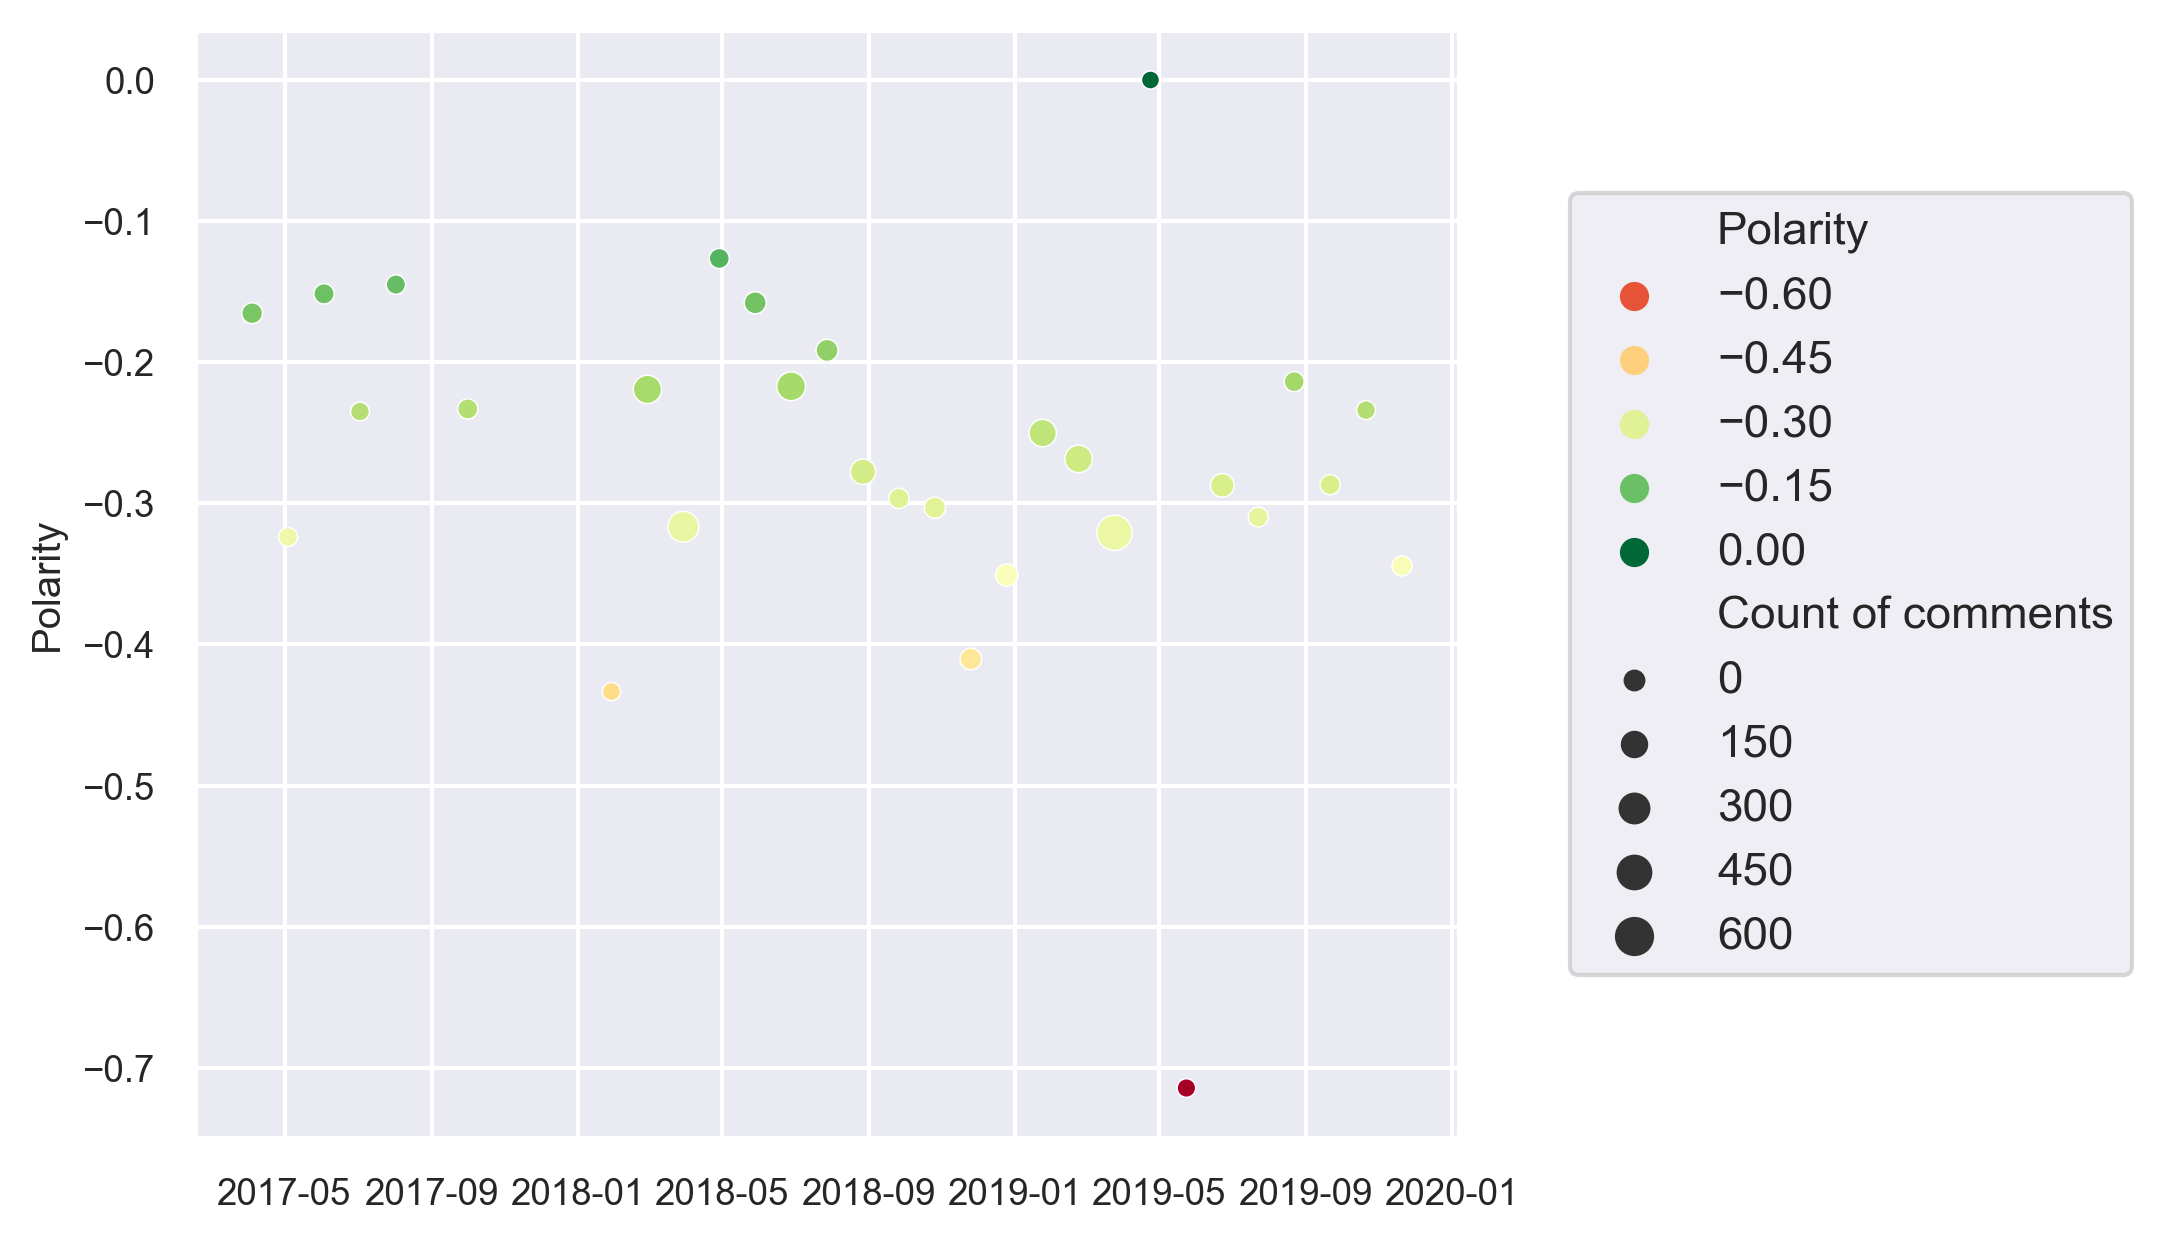

In [24]:
df_result = df_result.rename({'polarity': 'Polarity', 'summ': 'Count of comments'}, axis=1) 

plt.figure(dpi=300)
sns.set(font_scale=0.8)
ax = sns.scatterplot(
    x='date', y='Polarity', 
    hue="Polarity",
    size="Count of comments", 
    data=df_result, palette='RdYlGn', legend='brief', markers=True)
sns.set(font_scale=1.0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
leg = ax.legend(loc='center right', bbox_to_anchor=(1.55, 0.5), ncol=1)
for t in leg.texts:
    txt = t.get_text()
    if txt.startswith('0.8'):
        txt = '0.8'
    t.set_text(txt.replace('1.6', '1.0'))
xticks = ax.get_xticks()

ax.set_xlabel('')
ax.set_ylabel('Polarity')
plt.show()

In [25]:
fig = px.scatter(df_result, x="date", y="Polarity", trendline="ols")
fig.show()

# Posts location

In [26]:
def generateBaseMap(default_location=[51.107771, 17.038651], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles='cartodbpositron')
    return base_map

In [27]:
lbl_colors = {
    'accident': 'red',
    'malfunction': 'orange',
    'incident': 'blue',
    'unknown': 'gray'
}

lbl_icon = {
    'accident': 'times-circle',
    'malfunction': 'exclamation',
    'incident': 'clock-o',
    'unknown': 'question'
}

m = folium.Map(
    location=[51.107771, 17.038651],
    zoom_start=12
)

marker_cluster = MarkerCluster(control=False)

feature_groups = { lbl: FeatureGroupSubGroup(marker_cluster, name=lbl) for lbl in set(df_posts['label'].tolist())}

for idx, row in df_posts.iterrows():
    lbl = row['label']
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"({row['label']}) {row['text']}",
        icon=folium.Icon(color=lbl_colors[lbl], icon=lbl_icon[lbl], prefix='fa')
    ).add_to(feature_groups[lbl])

m.add_child(marker_cluster)
for fg in feature_groups.values():
    m.add_child(fg)

m.add_child(folium.map.LayerControl())

m

In [28]:
base_map = generateBaseMap()
colors = {
    'accident':'#FF5252',
    'malfunction':'#FF9800',
    'incident':'#03A9F4',
    'unknown':'#BDBDBD'
}
cnt = 0
for i, j in df_posts.iterrows():
    label = j.label
    if label in colors.keys() and pd.notna(j.lat):
        marker_color = colors[label]
        lat = j.lat
        lon = j.lon
        reactions = j.angry + j.haha + j.like + j.love + j.sad + j.wow
        folium.CircleMarker(
            location=[j.lat, j.lon],
            radius=2,
            color=marker_color,
            fill_color=marker_color,
            fill_opacity=1,
        ).add_to(base_map)
        cnt += 1

folium.TileLayer('openstreetmap').add_to(base_map)
folium.LayerControl().add_to(base_map)
base_map

# Count of reactions

In [29]:
base_map = generateBaseMap()
colors = {
    'accident':'#FF5252',
    'malfunction':'#FF9800',
    'incident':'#03A9F4',
    'unknown':'#BDBDBD'
}
for i, j in df_posts.iterrows():
    label = j.label
    if label in colors.keys() and pd.notna(j.lat):
        marker_color = colors[label]
        lat = j.lat
        lon = j.lon
        reactions = j.angry + j.haha + j.like + j.love + j.sad + j.wow
        folium.CircleMarker(
            location=[j.lat, j.lon],
            radius=1 + reactions * 0.5,
            color=marker_color,
            fill_color=marker_color,
            fill_opacity=0.2,
            stroke=False
        ).add_to(base_map)


folium.LayerControl().add_to(base_map)
base_map

# Comments by year

In [30]:
base_map = generateBaseMap()
for year in range(2017, 2020):
    df_temp = df_posts[df_posts.year==year].copy()
    HeatMap(data=df_temp[['lat', 'lon', 'comments_count']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(
        folium.FeatureGroup(name=year).add_to(base_map)
        )
folium.LayerControl().add_to(base_map)
base_map

# Positive comments by year

In [31]:
base_map = generateBaseMap()
for year in range(2017, 2020):
    df_temp = df_posts[df_posts.year==year].copy()
    df_temp = df_temp[df_temp['positive_comm'] > 0]
    HeatMap(data=df_temp[['lat', 'lon', 'positive_comm']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(
        folium.FeatureGroup(name=year).add_to(base_map)
        )
folium.LayerControl().add_to(base_map)
base_map